In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
AppleStock = pd.read_excel('applestock.xlsx','Sheet1')
GDP = pd.read_excel('GDP.xlsx','Sheet1')

AppleStock['Date'] = pd.to_datetime(AppleStock['Date'])
GDP['DATE'] = pd.to_datetime(GDP['DATE'])

AppleStock.set_index('Date',inplace=True)
GDP.set_index('DATE',inplace=True)

data = pd.merge(AppleStock,GDP,left_index=True,right_index=True,how='inner')
data.tail(20)

,Close,GDP
2019-07-01,53.2600,104.72530
2019-10-01,62.1900,105.93081
2020-01-01,77.3775,106.99007
2020-04-01,73.4500,132.96365
2020-07-01,106.2600,124.47265
2020-10-01,108.8600,125.98604
2021-01-01,131.9600,124.47938
2021-04-01,131.4600,122.48408
2021-07-01,145.8600,119.30400
2021-10-01,149.8000,120.12854


In [4]:
#log_tranfoormation
data['Close_log'] = np.log(data['Close'])
data['GDP_log'] = np.log(data['GDP'])

# Define lag
lag = 1

# Create lagged variables
data['apple_lag'] = data['Close_log'].shift(lag)

# Drop rows with NaN values introduced by shifting
data.dropna(inplace=True)
data.tail(20)
print(data.count())

Close        173
GDP          173
Close_log    173
GDP_log      173
apple_lag    173
dtype: int64


In [5]:

class TARModel:
    def __init__(self, lag, threshold):
        self.lag = lag
        self.threshold = threshold
        self.model1 = None
        self.model2 = None

    def fit(self, data):
        # Create regimes based on GDP log threshold
        regime1 = data['GDP_log'] <= self.threshold
        regime2 = data['GDP_log'] > self.threshold

        if regime1.sum() == 0 or regime2.sum() == 0:
            raise ValueError("One of the regimes has zero samples. Adjust the threshold.")

        # Add constant term for statsmodels
        X_regime1 = sm.add_constant(data[regime1][['apple_lag', 'GDP_log']])
        X_regime2 = sm.add_constant(data[regime2][['apple_lag', 'GDP_log']])
        y_regime1 = data[regime1]['Close_log']
        y_regime2 = data[regime2]['Close_log']
        # Fit models for each regime using OLS
        self.model1 = sm.OLS(y_regime1, X_regime1).fit()
        self.model2 = sm.OLS(y_regime2, X_regime2).fit()

        print(self.model1.summary())
        print(self.model2.summary())

        # Compute residuals
        residuals1 = self.model1.resid
        residuals2 = self.model2.resid

        plt.scatter(data.index[regime1], residuals1, label='Regime 1 Residuals')
        plt.scatter(data.index[regime2], residuals2, label='Regime 2 Residuals')
        plt.title('OLS Residuals for Each Regime')
        plt.legend()
        plt.show()

    def predict(self, data):
        # Create regimes based on GDP lag threshold
        regime1 = data['GDP_log'] <= self.threshold
        regime2 = data['GDP_log'] > self.threshold

        # Add constant term for statsmodels
        X_regime1 = sm.add_constant(data[regime1][['apple_lag', 'GDP_log']])
        X_regime2 = sm.add_constant(data[regime2][['apple_lag', 'GDP_log']])
        
        # Prepare an empty array for predictions
        predictions = np.zeros(len(data))

        # Predict using the appropriate model for each regime
        predictions[regime1] = self.model1.predict(X_regime1)
        predictions[regime2] = self.model2.predict(X_regime2)
        
        return predictions


                            OLS Regression Results                            
Dep. Variable:              Close_log   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                     888.6
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           2.25e-67
Time:                        00:46:04   Log-Likelihood:                -1.7236
No. Observations:                 110   AIC:                             9.447
Df Residuals:                     107   BIC:                             17.55
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4680      0.597     -0.784      0.4

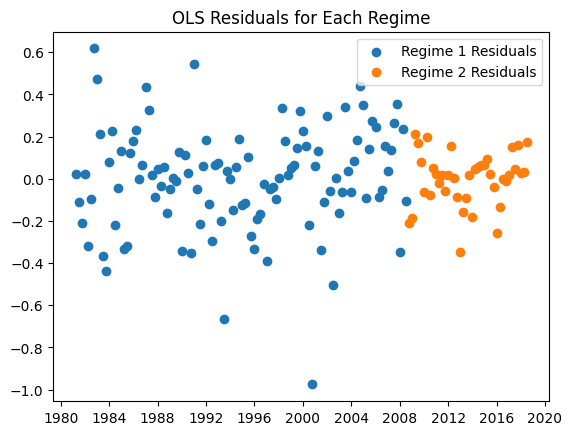

Training MSE: 0.048470218691200946
Training MAE: 0.1606937554632511
Test MSE: 0.029543472132477915
Test MAE: 0.14666487439986597


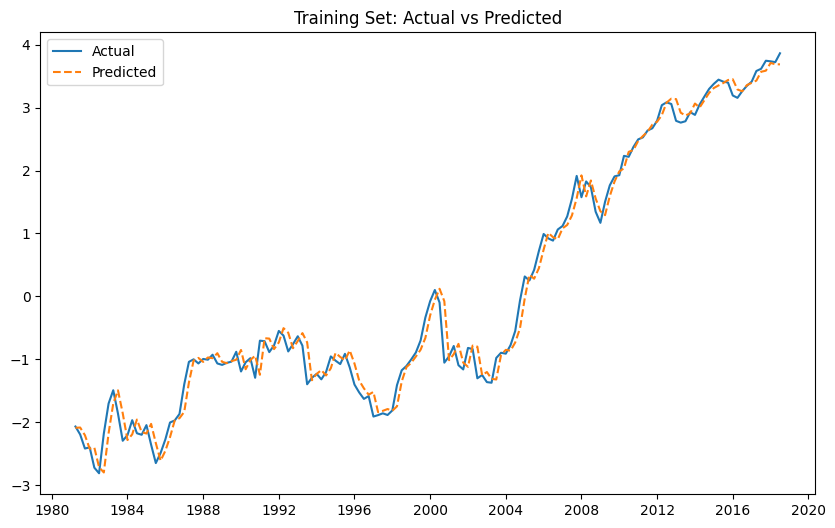

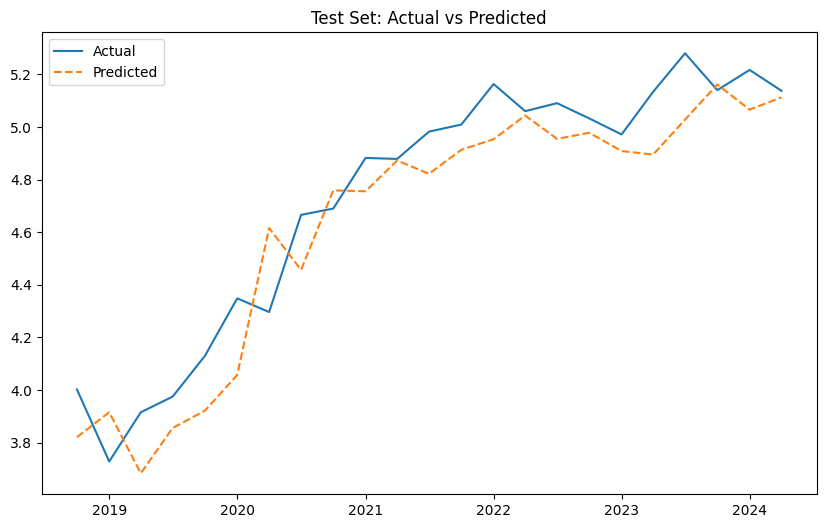

In [6]:
# Split data into training and test sets
train = data[:150].copy()
test = data[150:].copy()
# Fit the model on the training data
tar_model = TARModel(lag=1, threshold=data['GDP_log'].mean())#np.percentile(data['GDP_log'],25)
tar_model.fit(train)

# Make predictions on the training set
train_predictions = tar_model.predict(train)

# Make predictions on the test set
test_predictions = tar_model.predict(test)

# Calculate performance metrics
train_mse = mean_squared_error(train['Close_log'], train_predictions)
train_mae = mean_absolute_error(train['Close_log'], train_predictions)
print(f'Training MSE: {train_mse}')
print(f'Training MAE: {train_mae}')

test_mse = mean_squared_error(test['Close_log'], test_predictions)
test_mae = mean_absolute_error(test['Close_log'], test_predictions)
print(f'Test MSE: {test_mse}')
print(f'Test MAE: {test_mae}')

# Plot the actual vs predicted values for the training set
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Close_log'], label="Actual")
plt.plot(train.index, train_predictions, label="Predicted", linestyle="--")
plt.title("Training Set: Actual vs Predicted")
plt.legend()
plt.show()

# Plot the actual vs predicted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Close_log'], label="Actual")
plt.plot(test.index, test_predictions, label="Predicted", linestyle="--")
plt.title("Test Set: Actual vs Predicted")
plt.legend()
plt.show()
